# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Загружаем разметку

In [2]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = './data/fish/train'

def load_boxes():
    boxes = dict()
    for path in glob('./data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [3]:
boxes = load_boxes()  # разметка детекций

In [4]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

,class,count
0,alb,1719
1,shark,176
2,yft,734
3,bet,200
4,lag,67
5,dol,117


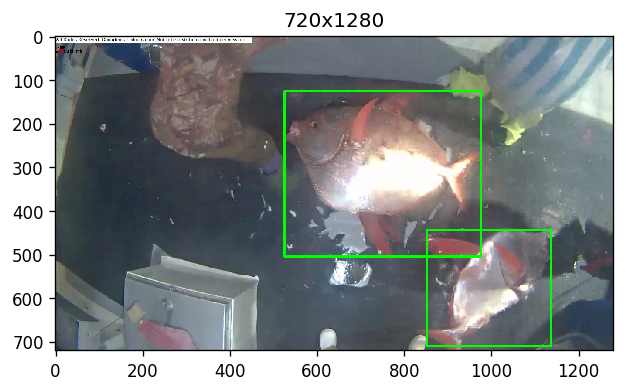

In [5]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['lag'][17])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

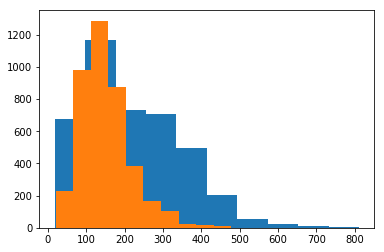

In [6]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [7]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

# Сетка якорей (anchor grid)

In [8]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [9]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, cl, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., cl[0], cl[1], cl[2], cl[3], cl[4], cl[5], dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, cl0, cl1, cl2, cl3, cl4, cl5, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            cnf = []
            for i in [cl0, cl1, cl2, cl3, cl4, cl5]:
                cnf.append(_sigmoid(i))
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                    'ALB': cnf[0],
                                    'SHARK': cnf[1],
                                    'YFT': cnf[2],
                                    'BET': cnf[3],
                                    'LAG': cnf[4],
                                    'DOL': cnf[5],
                                      })
    return rectangles

### Валидация енкодинга/декодинга

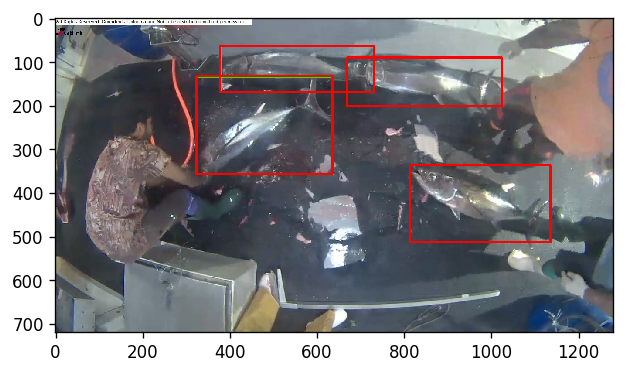

In [10]:
example = boxes['alb'][174]
cl = [0, 0, 1, 0, 0, 0]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH), cl)

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10]))

In [11]:
encoded.shape

(23, 37, 11)

In [12]:
decoded

[{'x': 555.4999991848663,
  'y': 117.00000000874634,
  'width': 353.0000030994415,
  'height': 106.0000017285347,
  'conf': 0.731058573739949,
  'ALB': 0.5,
  'SHARK': 0.5,
  'YFT': 0.731058573739949,
  'BET': 0.5,
  'LAG': 0.5,
  'DOL': 0.5},
 {'x': 847.0000024582889,
  'y': 146.4999999934504,
  'width': 356.0000002384186,
  'height': 111.00000143051147,
  'conf': 0.731058573739949,
  'ALB': 0.5,
  'SHARK': 0.5,
  'YFT': 0.731058573739949,
  'BET': 0.5,
  'LAG': 0.5,
  'DOL': 0.5},
 {'x': 480.4999994265067,
  'y': 245.99999921477362,
  'width': 311.00000739097595,
  'height': 224.00000095367432,
  'conf': 0.731058573739949,
  'ALB': 0.5,
  'SHARK': 0.5,
  'YFT': 0.731058573739949,
  'BET': 0.5,
  'LAG': 0.5,
  'DOL': 0.5},
 {'x': 975.5000019395675,
  'y': 425.4999997985104,
  'width': 322.99999594688416,
  'height': 177.0000010728836,
  'conf': 0.731058573739949,
  'ALB': 0.5,
  'SHARK': 0.5,
  'YFT': 0.731058573739949,
  'BET': 0.5,
  'LAG': 0.5,
  'DOL': 0.5}]

## Функция потерь

In [13]:
K = tf.keras.backend
from keras.utils import to_categorical



def confidence_loss(y_true, y_pred):
   
    conf_loss = K.categorical_crossentropy(y_true[..., 0:7], 
                                     y_pred[..., 0:7],
                                    from_logits=True)    
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 7:] - y_pred[..., 7:])
    square_loss = 0.5 * K.square(y_true[..., 7:] - y_pred[..., 7:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)


def total_loss(y_true, y_pred, neg_pos_ratio=4, ):
    batch_size = K.shape(y_true)[0]
    
    

    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

    
    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * K.sum(y_true[..., 0:7], axis=-1), axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - K.sum(y_true[..., 0:7], axis=-1)),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss 

Using TensorFlow backend.


## Загрузка данных

In [14]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    classes = list(boxes.keys())
    cls = []
    for i in classes:
        cls.append(i.upper())
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                z = boxes[j]['filename']
                z = z[18: z.rfind('/')]
                a = []
                for i in cls:
                    if i == z: 
                        b = 1.0
                    else: b = 0.0
                    a.append(b)
                y.append(encode_anchors(boxes[j], img_shape, a))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [15]:
output = keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = keras.layers.Conv2D(11,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2')(output)

model = keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 750, 1200, 3)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0         
__________

## Обучение

In [16]:
opt = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=opt, 
              loss=total_loss,
              metrics={'conf_loss': confidence_loss})

In [18]:
batch_size = 3
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = keras.callbacks.ModelCheckpoint(
    'weights.{epoch:02d}-{loss:.3f}.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    callbacks=[checkpoint])

Epoch 1/1
  47/1004 [>.............................] - ETA: 14:18 - loss: 6.2181

KeyboardInterrupt: 

## Результат работы детектора

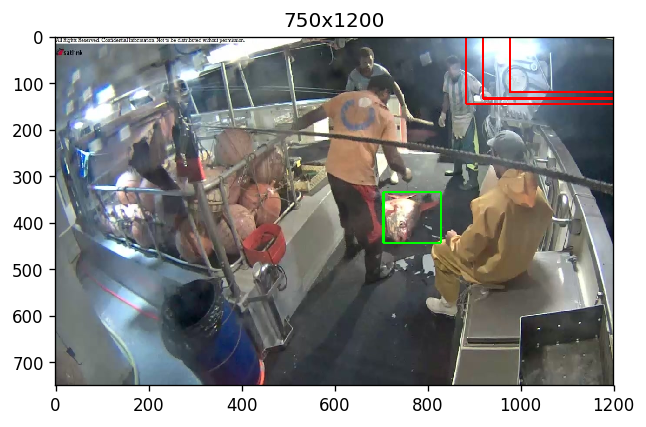

In [19]:
example = boxes['lag'][29]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))[0]

decoded = decode_prediction(pred, conf_thr=0.7)
decoded = sorted(decoded, key=lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:3], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

In [20]:
decoded

[{'x': 1089.7133820765728,
  'y': 32.5749406348104,
  'width': 412.390261888504,
  'height': 225.18577873706818,
  'conf': 1.0,
  'ALB': 1.0,
  'SHARK': 1.0,
  'YFT': 1.0,
  'BET': 1.0,
  'LAG': 1.0,
  'DOL': 1.0},
 {'x': 1151.2605141521105,
  'y': 24.036533920013387,
  'width': 460.90461015701294,
  'height': 221.7693641781807,
  'conf': 1.0,
  'ALB': 1.0,
  'SHARK': 1.0,
  'YFT': 1.0,
  'BET': 1.0,
  'LAG': 1.0,
  'DOL': 1.0},
 {'x': 1194.2464441262389,
  'y': 12.095175100409467,
  'width': 431.59321546554565,
  'height': 216.54210090637207,
  'conf': 1.0,
  'ALB': 1.0,
  'SHARK': 1.0,
  'YFT': 1.0,
  'BET': 1.0,
  'LAG': 1.0,
  'DOL': 1.0},
 {'x': 162.7396260564392,
  'y': 40.984887370596766,
  'width': 398.3015835285187,
  'height': 212.70480304956436,
  'conf': 1.0,
  'ALB': 1.0,
  'SHARK': 1.0,
  'YFT': 1.0,
  'BET': 1.0,
  'LAG': 1.0,
  'DOL': 1.0},
 {'x': 216.37278392508225,
  'y': 34.08302042795265,
  'width': 412.4449610710144,
  'height': 205.66919893026352,
  'conf': 1.0,
 

## Агрегация результатов

In [36]:
test_files = [im for im in os.listdir(TEST_DIR)]
test = np.ndarray((len(test_files), ROWS, COLS, CHANNELS), dtype=np.uint8)

for i, im in enumerate(test_files): 
    test[i] = read_image(TEST_DIR+im)
    
test_preds = model.predict(test, verbose=1)

NameError: name 'TEST_DIR' is not defined

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0